## Hand Made model의 평가

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


sklearn version:  1.2.0
TF version:  2.10.1
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Add,  Dense, Conv2D, Activation
from keras.models import Sequential

In [3]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [4]:
import csv
def load_Emist():
    X_train=np.load('X_train.npy')
    y_train=np.load('y_train.npy')
    X_valid=np.load('X_valid.npy')
    y_valid=np.load('y_valid.npy')
    return X_train, y_train, X_valid, y_valid


In [6]:
X_train, y_train, X_valid, y_valid = load_Emist()
X_train.shape,X_train.dtype

((533917, 28, 28), dtype('uint8'))

In [7]:
#data, batch size 성정
train_size=len(X_train)
valid_size=len(X_valid)
batch_size=32

In [8]:
X_train=np.reshape(X_train,[-1,784])
X_valid=np.reshape(X_valid,[-1,784])

In [9]:
y_train=np.reshape(y_train,[-1,1])
y_valid=np.reshape(y_valid,[-1,1])

In [10]:
train_full = np.append(X_train,y_train,axis=1)
valid_full = np.append(X_valid,y_valid,axis=1)

In [11]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:03d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [12]:
train_filepaths = save_to_multiple_csv_files(train_full, "train")
valid_filepaths = save_to_multiple_csv_files(valid_full, "valid")

In [13]:
n_inputs = X_train.shape[-1]
def preprocess_make(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    resized_image = x
    final_image = resized_image/255.
    return final_image, y

In [14]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess_make, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [15]:
train_set = csv_reader_dataset(train_filepaths,batch_size=batch_size, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths,batch_size=batch_size, repeat=None)

In [16]:
early_stopping_BRN50 = EarlyStopping(patience = 5)
data_name="byclass" 
type_name="make"
hypara="adam"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [17]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
lr = keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr])

Epoch 1/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.6228 - accuracy: 0.7982
Epoch 1: val_loss improved from inf to 0.40338, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 129s 8ms/step - loss: 0.6228 - accuracy: 0.7982 - val_loss: 0.4034 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 2/1000
16678/16684 [============================>.] - ETA: 0s - loss: 0.4435 - accuracy: 0.8424
Epoch 2: val_loss improved from 0.40338 to 0.37463, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 126s 8ms/step - loss: 0.4435 - accuracy: 0.8424 - val_loss: 0.3746 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 3/1000
16679/16684 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8524
Epoch 3: val_loss improved from 0.37463 to 0.35506, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 127s 8ms/step - loss: 0.4082 - accuracy: 0.8524 - val_loss: 0.3551 - val_accuracy: 0

<AxesSubplot: >

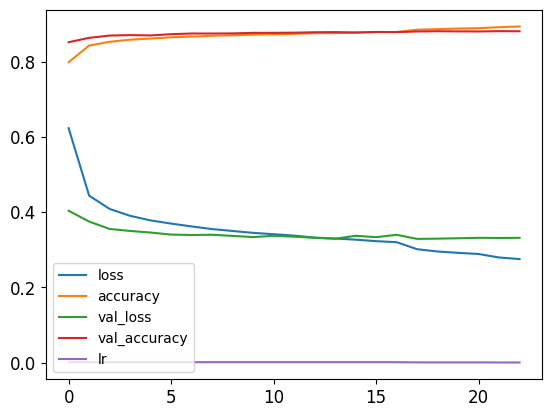

In [18]:
pd.DataFrame(history.history).plot()

In [24]:
model2 = Sequential()
model2.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model2.add(BatchNormalization())
model2.add(Conv2D(64, 2, activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2))

model2.add(Conv2D(128, 2, activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2))
model2.add(Dropout(0.25))
model2.add(Flatten())

model2.add(Dense(1000, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1000, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(62, activation='softmax'))


tf.keras.backend.clear_session()
optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
lr = keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3)
history=model2.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr])

Epoch 1/1000
16679/16684 [============================>.] - ETA: 0s - loss: 0.6135 - accuracy: 0.8004
Epoch 1: val_loss did not improve from 0.32865
16684/16684 [==============================] - 137s 8ms/step - loss: 0.6134 - accuracy: 0.8004 - val_loss: 0.3975 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 2/1000
16682/16684 [============================>.] - ETA: 0s - loss: 0.4439 - accuracy: 0.8420
Epoch 2: val_loss did not improve from 0.32865
16684/16684 [==============================] - 136s 8ms/step - loss: 0.4439 - accuracy: 0.8420 - val_loss: 0.3726 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 3/1000
16680/16684 [============================>.] - ETA: 0s - loss: 0.4122 - accuracy: 0.8513
Epoch 3: val_loss did not improve from 0.32865
16684/16684 [==============================] - 136s 8ms/step - loss: 0.4122 - accuracy: 0.8513 - val_loss: 0.3644 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 4/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.3967 - accuracy: 0.8560
E

<AxesSubplot: >

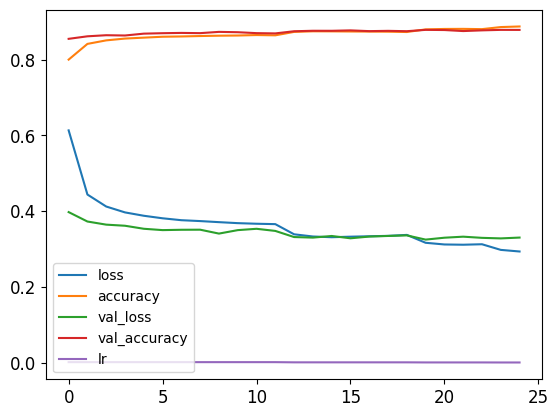

In [25]:
pd.DataFrame(history.history).plot()

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        8256      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                        

In [87]:
x_train=pd.read_csv('emnist-byclass-train.csv',header=None)
x_test=pd.read_csv('emnist-byclass-test.csv',header=None)

def data_load(data_type_train,data_type_test):
    x_train =data_type_train.iloc[:, 1:].values.astype('float32')
    y_train = data_type_train.iloc[:, 0].values
    x_test = data_type_test.iloc[:, 1:].values.astype('float32')
    y_test = data_type_test.iloc[:, 0].values
    x_train = x_train.reshape(x_train.shape[0], 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 28, 28)
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test=data_load(x_train,x_test)

In [88]:
x_test=x_test.reshape(-1,28,28,1)

In [89]:
x_test.shape

(116323, 28, 28, 1)

In [90]:
y_test.shape

(116323,)

In [91]:
from sklearn.metrics import confusion_matrix

In [93]:
y_true= y_test
y_pred= model2.evaluate(x_test,y_test)

3636/3636 [==============================] - 5s 1ms/step - loss: 2303.8103 - accuracy: 0.0604


In [64]:
y_pred_c=np.argmax(y_pred,axis=1)

In [65]:
confu=confusion_matrix(y_true, y_pred_c)

In [44]:
confu

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [48]:
labels= np.arange(62)

In [51]:
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [66]:
set(y_pred_c)

{2,
 7,
 10,
 11,
 13,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 25,
 26,
 27,
 28,
 30,
 32,
 33,
 34,
 35,
 42,
 48,
 52}

In [70]:
y_pred_c[:600]

array([16, 16, 16, 35, 22, 16, 16, 16, 16, 15, 35, 17, 35, 34, 35, 16, 16,
       32, 15, 16, 16, 34, 34, 20, 16, 16, 35, 16, 16, 22, 32, 15, 15, 18,
       16, 16, 16, 16, 16, 15, 16, 32, 10, 16, 16, 18, 16, 16, 30, 16, 16,
       16, 15, 15, 16, 16, 32, 34, 16, 15, 20, 16, 13, 16, 17, 35, 15, 20,
       16, 16, 16, 16, 16, 15, 32, 16, 16, 22, 20, 16, 32, 34, 16, 35, 17,
       16, 16, 16, 18, 16, 15, 15, 18, 16, 16, 16, 16, 35, 32, 16, 16, 16,
       15, 16, 22, 16, 35, 22, 16, 15, 16, 16, 32, 16, 20, 34, 22, 16, 18,
       15, 16, 16, 16, 16, 16, 16, 16, 32, 35, 16, 16, 16, 15, 15, 35, 35,
       16, 16, 16, 16, 22, 16, 16, 16, 18, 15, 35, 16, 16, 16, 35, 15, 16,
       16, 18, 18, 16, 17, 32, 16, 15, 13, 15, 16, 35, 16, 16, 16, 16, 16,
       18, 16, 10, 22, 10, 18, 16, 34, 16, 16, 16, 16, 16, 34, 16, 30, 16,
       22, 22, 10, 15, 16, 16, 22, 32, 10, 35, 16, 16, 16, 22, 16, 16, 16,
       16, 16, 16, 15, 16, 22, 16, 16, 15, 15, 16, 16, 16, 30, 16, 15, 16,
       16, 15, 16, 16, 16

In [95]:
model3 = keras.models.load_model("byclass_make_adam.h5")

In [103]:
test_filepaths = save_to_multiple_csv_files(valid_full, "test")
test_set = csv_reader_dataset(test_filepaths,batch_size=batch_size, repeat=None)

## hand-made model의 평가

In [ ]:
y_true= y_test
y_pred= model3.evaluate(test_set)

  86053/Unknown - 298s 3ms/step - loss: 0.3266 - accuracy: 0.8783

In [ ]:
plot_confusion_matrix(confu, labels=y_test, normalize=True)

## Baseline model 정의 및 훈련과 평가

In [ ]:
#####LENET-5 정의
from tensorflow.keras import layers, models
model3 = models.Sequential()
model3.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,1)))
model3.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model3.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(120, activation='relu'))
model3.add(layers.Dense(84, activation='relu'))
model3.add(layers.Dense(62, activation='softmax'))

In [ ]:
early_stopping = EarlyStopping(patience = 10)
data_name="byclass"
type_name="LN5"
checkpoint_callback = ModelCheckpoint(data_name+"_"+type_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history3=model3.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping, checkpoint_callback])

Epoch 1/1000
16678/16684 [============================>.] - ETA: 0s - loss: 0.5777 - accuracy: 0.8077
Epoch 1: val_loss improved from inf to 0.45623, saving model to byclass_LN5.h5
16684/16684 [==============================] - 134s 8ms/step - loss: 0.5776 - accuracy: 0.8077 - val_loss: 0.4562 - val_accuracy: 0.8379
Epoch 2/1000
16680/16684 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8468
Epoch 2: val_loss improved from 0.45623 to 0.41630, saving model to byclass_LN5.h5
16684/16684 [==============================] - 123s 7ms/step - loss: 0.4259 - accuracy: 0.8468 - val_loss: 0.4163 - val_accuracy: 0.8510
Epoch 3/1000
16681/16684 [============================>.] - ETA: 0s - loss: 0.3995 - accuracy: 0.8544
Epoch 3: val_loss improved from 0.41630 to 0.41325, saving model to byclass_LN5.h5
16684/16684 [==============================] - 103s 6ms/step - loss: 0.3996 - accuracy: 0.8544 - val_loss: 0.4133 - val_accuracy: 0.8513
Epoch 4/1000
16677/16684 [============

16684/16684 [==============================] - 136s 8ms/step - loss: 0.3450 - accuracy: 0.8690 - val_loss: 0.3858 - val_accuracy: 0.8590


In [ ]:
from tensorflow.keras import layers, models
model4 = models.Sequential()
model4.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,1)))
model4.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model4.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(120, activation='relu'))
model4.add(layers.Dense(84, activation='relu'))
model4.add(layers.Dense(62, activation='softmax'))

early_stopping2 = EarlyStopping(patience = 10)
data_name="byclass"
type_name="LN5"
checkpoint_callback2 = ModelCheckpoint(data_name+"_"+type_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#nesteroV 사용해보기
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

model4.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history4=model4.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping2, checkpoint_callback2])

Epoch 1/1000
16681/16684 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.7368
Epoch 1: val_loss improved from inf to 0.57336, saving model to byclass_LN5.h5
16684/16684 [==============================] - 118s 7ms/step - loss: 0.8854 - accuracy: 0.7368 - val_loss: 0.5734 - val_accuracy: 0.8080
Epoch 2/1000
16681/16684 [============================>.] - ETA: 0s - loss: 0.5216 - accuracy: 0.8220
Epoch 2: val_loss improved from 0.57336 to 0.50539, saving model to byclass_LN5.h5
16684/16684 [==============================] - 118s 7ms/step - loss: 0.5216 - accuracy: 0.8220 - val_loss: 0.5054 - val_accuracy: 0.8243
Epoch 3/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.4761 - accuracy: 0.8338
Epoch 3: val_loss improved from 0.50539 to 0.46884, saving model to byclass_LN5.h5
16684/16684 [==============================] - 118s 7ms/step - loss: 0.4762 - accuracy: 0.8338 - val_loss: 0.4688 - val_accuracy: 0.8362
Epoch 4/1000
16679/16684 [============

16684/16684 [==============================] - 90s 5ms/step - loss: 0.3494 - accuracy: 0.8691 - val_loss: 0.3851 - val_accuracy: 0.8594
Epoch 28/1000
16673/16684 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8713
Epoch 28: val_loss did not improve from 0.38323
16684/16684 [==============================] - 89s 5ms/step - loss: 0.3408 - accuracy: 0.8713 - val_loss: 0.3876 - val_accuracy: 0.8578
Epoch 29/1000
16677/16684 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8719
Epoch 29: val_loss did not improve from 0.38323
16684/16684 [==============================] - 89s 5ms/step - loss: 0.3378 - accuracy: 0.8719 - val_loss: 0.3878 - val_accuracy: 0.8594
Epoch 30/1000
16673/16684 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8708
Epoch 30: val_loss did not improve from 0.38323
16684/16684 [==============================] - 89s 5ms/step - loss: 0.3421 - accuracy: 0.8708 - val_loss: 0.3871 - val_accuracy: 0.8603
Epo

In [82]:

model3 = tf.keras.models.load_model("byclass_LN5.h5")



In [84]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [56]:

hand1=pd.read_csv('emnist_handwriting_20180565_psm.csv',header=None)
hand2=pd.read_csv('emnist_handwriting_20230615_psm.csv',header=None)
hand3=pd.read_csv('emnist_handwriting_20180611_psm.csv',header=None)
hand4=pd.read_csv('ha.csv',header=None)
xh_test=np.concatenate((hand1,hand2,hand3,hand4))


In [116]:
xh_test.shape

(2560, 785)

In [138]:
def data_load_test(data_type_test):
    x_test = data_type_test.iloc[:, 1:].values.astype('float32')
    y_test = data_type_test.iloc[:, 0].values
    x_test = x_test.reshape(x_test.shape[0], 28, 28)
    return x_test,y_test

In [140]:
x_test,y_test=data_load_test(pd.DataFrame(aaa))

In [141]:
test_size=len(x_test)
batch_size=32

In [142]:
x_test=np.reshape(x_test,[-1,784])
y_test=np.reshape(y_test,[-1,1])
test_full = np.append(x_test,y_test,axis=1)

In [143]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:03d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [144]:
test_filepaths = save_to_multiple_csv_files(test_full, "test")
n_inputs = x_test.shape[-1]

In [145]:
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    resized_image = tf.image.resize(x, [32, 32])
    
    final_image = resized_image/255
    
    return final_image, y

In [146]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [147]:
test_set = csv_reader_dataset(test_filepaths,batch_size=batch_size, repeat=None)


## Baseline 모델의 평가

In [157]:
model3.evaluate(test_set,steps=len(x_test)//batch_size)

80/80 [==============================] - 1s 5ms/step - loss: 0.3723 - accuracy: 0.8460
[0.372334678152693, 0.846015789]


In [ ]:
###찾기쉽게

In [ ]:
###마지막